In [1]:
import sys


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
from matplotlib import gridspec
import time
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from matplotlib.font_manager import FontProperties
import mplhep as hep
#hep.set_style(hep.style.CMS)
#hep.set_style("CMS") 
from matplotlib.colors import LogNorm

import os
os.environ['CUDA_VISIBLE_DEVICES']="1" #"1"

physical_devices = tf.config.list_physical_devices('GPU') 

tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [2]:
#Read in the data
data = pd.read_pickle("/clusterfs/ml4hep/yxu2/unfolding_mc_inputs/Data_nominal.pkl")
theta_unknown_S = data[['e_px','e_py','e_pz','jet_pt','jet_eta','jet_phi','jet_dphi','jet_qtnorm']].to_numpy()

scaler_data = StandardScaler()
scaler_data.fit(theta_unknown_S)

StandardScaler()

In [3]:
#Read in the MC
mc = pd.read_pickle("/clusterfs/ml4hep/yxu2/unfolding_mc_inputs/Rapgap_nominal.pkl")


theta0_G = mc[['gene_px','gene_py','gene_pz','genjet_pt','genjet_eta','genjet_phi','genjet_dphi','genjet_qtnorm']].to_numpy()
weights_MC_sim = mc['wgt']
#p_xyz = mc[["Q2"]].to_numpy()
pass_reco = np.array(mc['pass_reco'])
pass_truth = np.array(mc['pass_truth'])
pass_fiducial = np.array(mc['pass_fiducial'])

del mc
gc.collect()

22

In [4]:
NNweights_step2 = np.ones(len(theta0_G))
for i in range(5):
    mymodel = tf.keras.models.load_model("inputfiles/fullscan1/models/Rapgap_nominal_iteration"+str(i)+"_step2", compile=False)
    NNweights_step2_hold = mymodel.predict(scaler_data.transform(theta0_G),batch_size=10000)
    NNweights_step2_hold = NNweights_step2_hold/(1.-NNweights_step2_hold)
    NNweights_step2_hold = NNweights_step2_hold[:,0]
    NNweights_step2_hold = np.squeeze(np.nan_to_num(NNweights_step2_hold,posinf=1))
    NNweights_step2_hold[pass_truth==0] = 1.
    NNweights_step2 = NNweights_step2_hold*NNweights_step2

In [5]:
del mymodel
gc.collect()

37872

In [6]:
# Getting Q^2

#this is it anyways
#Q2 = theta0_G[:,8]

e_px = theta0_G[:,0]
e_py = theta0_G[:,1]

jet_pT = theta0_G[:,3]
jet_phi = theta0_G[:,5]

jet_px = np.multiply(jet_pT, np.cos(jet_phi))
jet_py = np.multiply(jet_pT, np.sin(jet_phi))

jet_qT = np.sqrt(np.square(e_px + jet_px) + np.square(e_py + jet_py))

#qT/Q
jet_qT_norm = theta0_G[:,7]   

one_over_Q = np.divide(jet_qT_norm, jet_qT)
Q = np.divide(1, one_over_Q)
Q_sq = np.square(Q, Q)

In [7]:
bins = {}

#jet pt
bins[3] = np.logspace(np.log10(10),np.log10(100),7)

#jet eta
bins[4] = np.linspace(-1,2.5,6)

#dphi
bins[6] = np.logspace(np.log10(0.03),np.log10(np.pi/2.0),9) - 0.03
bins[6] = bins[6][1:]
bins[6][0] = 0.0

#qt
bins[7] = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
bins[7] = bins[7][1:]
bins[7][0] = 0.0

symbol = {}
symbol[6] = '$\Delta\phi^\mathrm{jet}$ '
symbol[4] = '$\eta^\mathrm{jet}$'
symbol[7]  = '$q_\mathrm{T}^\mathrm{jet}/Q$'
symbol[3] = '$p_\mathrm{T}^\mathrm{jet}$'



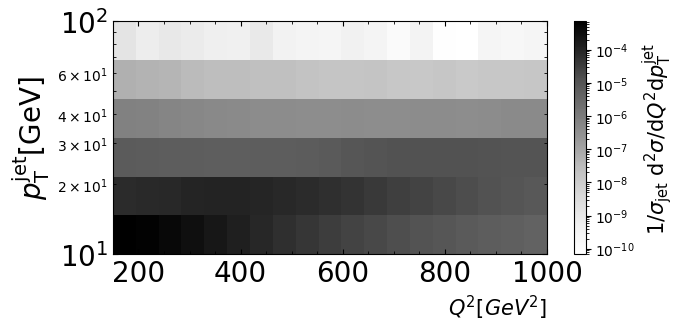

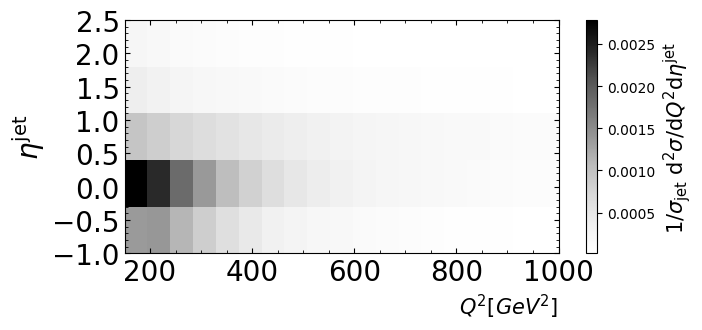

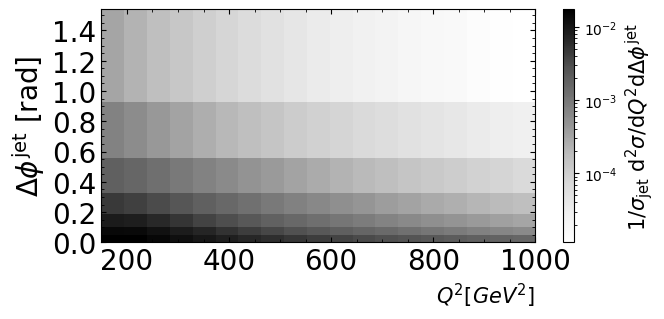

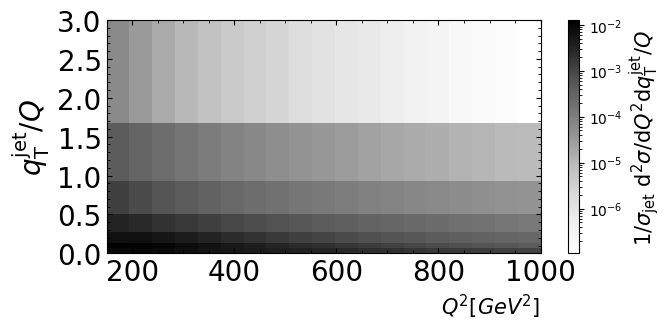

In [12]:



for i in [3,4,6,7]:
    fig = plt.figure(figsize=(7, 5)) 
    gs = gridspec.GridSpec(2, 1, height_ratios=[2,1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=20)
    if i!=4:
        plt.hist2d(Q_sq[pass_fiducial==1], theta0_G[:,i][pass_fiducial==1], bins = [np.linspace(150,1000,20), bins[i]],
        weights=weights_MC_sim[pass_fiducial==1]*NNweights_step2[pass_fiducial==1],density=True, cmap = 'Greys',norm=LogNorm())
    #'CMRmap', 'jet',  'prism',  
    else:
        plt.hist2d(Q_sq[pass_fiducial==1], theta0_G[:,i][pass_fiducial==1], bins = [np.linspace(150,1000,20), bins[i]],
    weights=weights_MC_sim[pass_fiducial==1]*NNweights_step2[pass_fiducial==1],density=True, cmap = 'Greys')

    if i == 3:
        plt.ylabel(symbol[i]+"[GeV]",fontsize=20)
    elif i == 6:
        plt.ylabel(symbol[i]+"[rad]",fontsize=20)
    else:
        plt.ylabel(symbol[i],fontsize=20)
    #plt.title("2D Distribution for Q_sq vs. Observable",loc="left",fontsize=20)
    #plt.text(0.05, 1.25,'H1 internal', horizontalalignment='center', verticalalignment='center', transform = ax0.transAxes, fontsize=25, fontweight='bold')
    plt.locator_params(axis='x', nbins=5)
    if i == 3:
        plt.yscale("log")
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.colorbar(orientation="vertical").set_label(label=r'$1/\sigma_\mathrm{jet}$ $\mathrm{d}^2\sigma/\mathrm{d}Q^{2}\mathrm{d}$%s'%symbol[i],size=15)

    ax0.set_xlabel('XLabel', loc='right')
    plt.xlabel("$Q^2 [GeV^2]$",fontsize=15)

    plt.show()

In [ ]:
fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=0)
plt.yticks(fontsize=20)
bin_for_Q_sq = np.logspace(np.log10(10),np.log10(100000),20)

Q2_data,bin_edges,_=plt.hist(Q_sq[pass_fiducial==1], bins = bin_for_Q_sq,
                weights=weights_MC_sim[pass_fiducial==1]*NNweights_step2[pass_fiducial==1],
                density=True,histtype="step",color="black",ls="-",label="Nominal Omnifold")

Q2_sim,_,_=plt.hist(Q_sq[pass_fiducial==1], bins = bin_for_Q_sq,
                weights=weights_MC_sim[pass_fiducial==1],
                density=True,histtype="step",color="black",ls=":",label="Rapgap Truth")

plt.ylabel("Normalized to unity",fontsize=20)
plt.title("Q^2 Distribution ",loc="left",fontsize=20)
plt.text(0.05, 1.25,'H1 internal', horizontalalignment='center', verticalalignment='center', transform = ax0.transAxes, fontsize=25, fontweight='bold')
plt.legend(frameon=False,fontsize=15)
plt.locator_params(axis='x', nbins=5)
plt.yscale("log")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.xlabel("Q^2 (GeV^2)",fontsize=15)


plt.show()

In [ ]:


bin_center = []
for i in range(len(bin_edges)-1):
    bin_center.append((bin_edges[i]+bin_edges[i+1])/2)

fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()   
plt.xticks(fontsize=0)
plt.yticks(fontsize=20)    
plt.plot(bin_center, Q2_sim,"ro",label="Rapgap Truth")
plt.plot(bin_center, Q2_data,"b*",label="Nominal Omnifold")

plt.ylabel("Normalized to unity",fontsize=20)
plt.title("Q^2 Distribution ",loc="left",fontsize=20)
plt.text(0.20, 1.25,'H1 internal', horizontalalignment='center', verticalalignment='center', transform = ax0.transAxes, fontsize=25, fontweight='bold')
plt.legend(frameon=False,fontsize=15)
plt.locator_params(axis='x', nbins=5)
plt.yscale("log")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.xlabel("Q^2 (GeV^2)",fontsize=15)
plt.show()

print(list(Q2_sim))
print(list(Q2_data))
print(bin_center)

In [ ]:
print(np.logspace(np.log10(10),np.log10(100000),20))